   ![Image Title](images/kc_logo.gif)

## Kings County House Price Analysis

* Student name: Filippe Fontenele
* Student pace: part-time
* Instructor name: Rajive Islam


## Overview

This project aims to build a model that assists homeowners and real estate agencies in identifying key components to add value to their homes while selling. To achieve this, we will be analyzing data from the King County House Sales dataset using multiple linear regression. The model will examine how renovating different components of a home will impact overall sales and help users make informed decisions.


## Business Problem

Homeowners and real estate agents need help to increase home sales profitability. We'll use King County House Sales data to identify renovation opportunities that can raise overall home prices. This info is useful in fluctuating markets to help homeowners and agencies maximize profits.

## OSEMN

This notebook uses the OSEMN (Obtain, Scrub, Explore, Model, Interpret) Data Science Process.

In [1]:
#Importing the necessary libraries 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
import scipy.stats as stats

### Obtain

The first step is obtaining the necessary data. On certain occasions, we already have the database at our disposal like in this case `kc_house_data.csv`, but that is not the norm. I will import and analyse the data, then select columns that will serve as useful predictors for a regression model.

In [3]:
#Get initial housing dataframe
kch_df = pd.read_csv("data/kc_house_data.csv")
kch_df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520


In [4]:
# Displaying the Column Names Markdown File

from IPython.display import Markdown, display
display(Markdown("data/column_names.md"))


# Column Names and Descriptions for King County Data Set

* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `sqft_garage` - Square footage of garage space
* `sqft_patio` - Square footage of outdoor porch or deck space
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `address` - The street address
* `lat` - Latitude coordinate
* `long` - Longitude coordinate

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model.


In [5]:
kch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

This is a large dataset containing over 30.000 entries and 25 columns. Most columns are numeric which are convenient for linear regression but there are also object entries that will have to be dealt with.

In [6]:
kch_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.015500e+04,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,4.538104e+09,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397
std,2.882587e+09,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
25%,2.064175e+09,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045
50%,3.874011e+09,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585
75%,7.287100e+09,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


### Scrub

With more knowledge of our data, we want to prepare the data for the model. Our target variable is `price` and the others are predictors.

In [7]:
# The dataset is comprised of 30155 entries
kch_df.isna().sum()
# heat_source has 23 null values
# and sewer_system has 14 null values
# very low number for such big dataset

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

In [8]:
kch_df['heat_source'].value_counts()

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

In [9]:
kch_df['sewer_system'].value_counts()

PUBLIC                25777
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

In [10]:
kch_df.dropna(inplace=True)
kch_df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
dtype: int64

### Explore

Now, we will perform an exploratory analysis to understand the relationships between the independent variables and the `price` variable.

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'sqft_above'}>],
       [<AxesSubplot:title={'center':'sqft_basement'}>,
        <AxesSubplot:title={'center':'sqft_garage'}>,
        <AxesSubplot:title={'center':'sqft_patio'}>,
        <AxesSubplot:title={'center':'yr_built'}>],
       [<AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>, <AxesSubplot:>]],
      dtype=object)

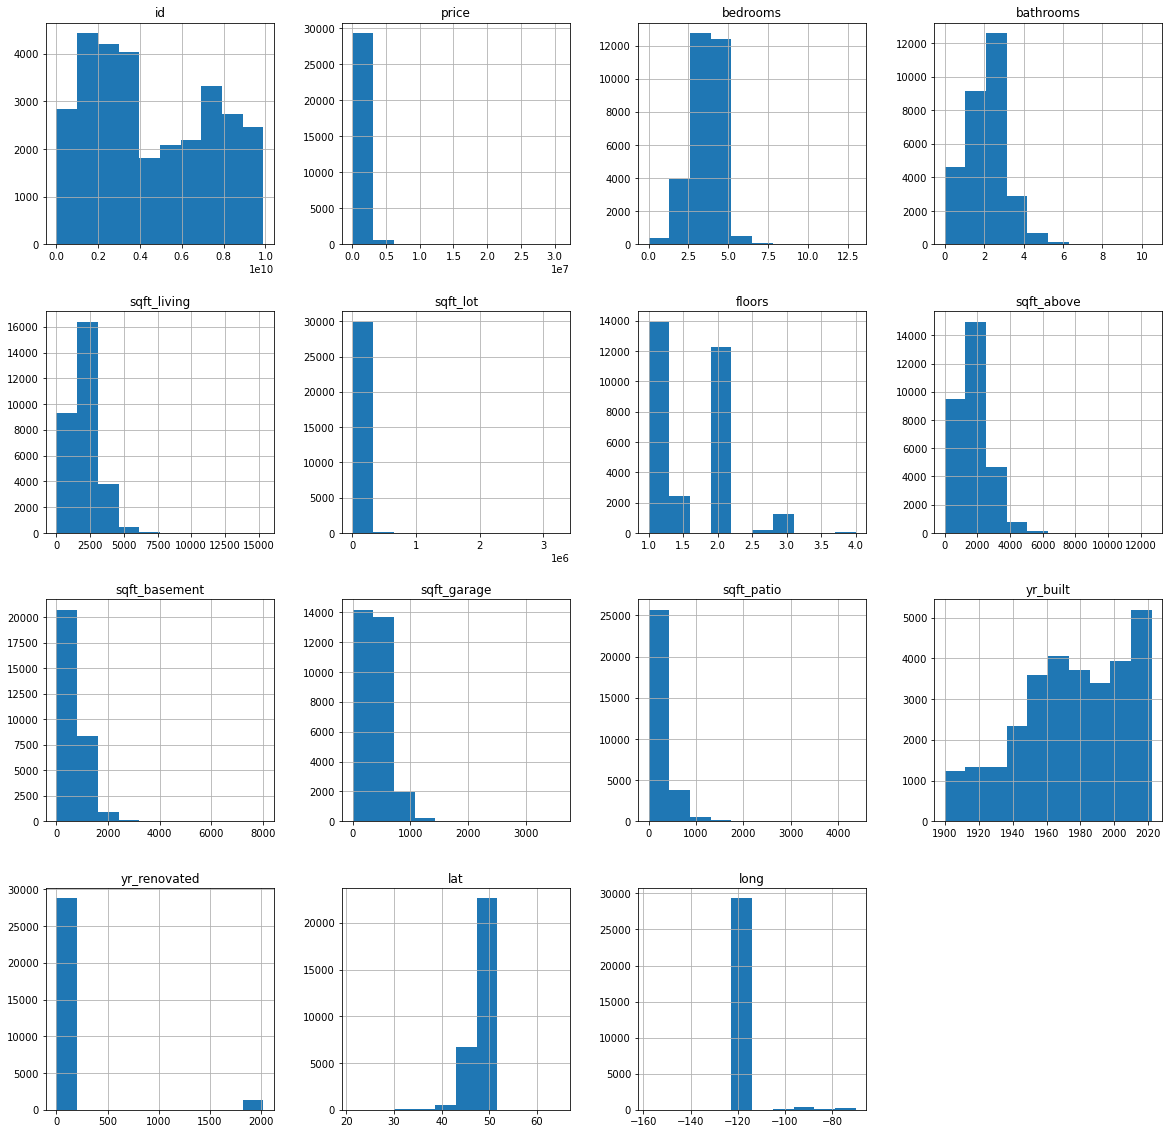

In [11]:
kch_df.hist(figsize = (20,20))

Looking at the numerical predictors, we notice none of them are normal and we can see a major skew either positive or negative in almost every histogram.

Our target variable `price` also show major positive skew.

Let's look first at the price distribution.

Before dealing with categoricals, let's take a closer look at some numerical features to further understand the data set.

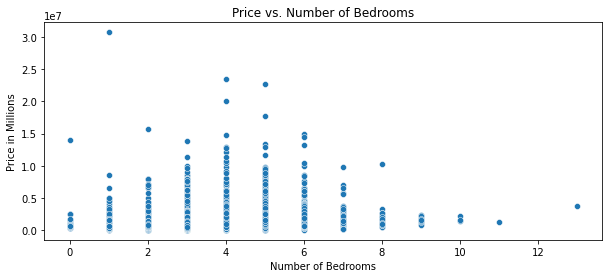

In [12]:
plt.figure(figsize = (10,4))
PvF = sns.scatterplot(x=kch_df['bedrooms'], y=kch_df['price'], data=kch_df)
PvF.set(xlabel = 'Number of Bedrooms', ylabel = 'Price in Millions')
plt.title('Price vs. Number of Bedrooms')
plt.show()

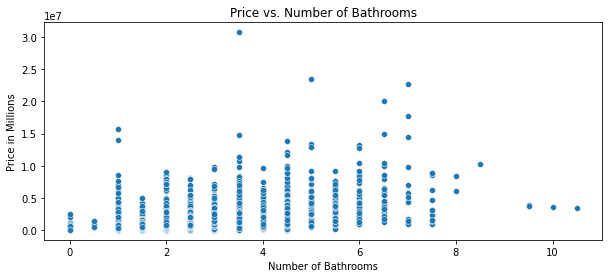

In [13]:
plt.figure(figsize = (10,4))
PvC = sns.scatterplot(x=kch_df['bathrooms'], y=kch_df['price'], data=kch_df)
PvC.set(xlabel = 'Number of Bathrooms', ylabel = 'Price in Millions')
plt.title('Price vs. Number of Bathrooms')
plt.show()

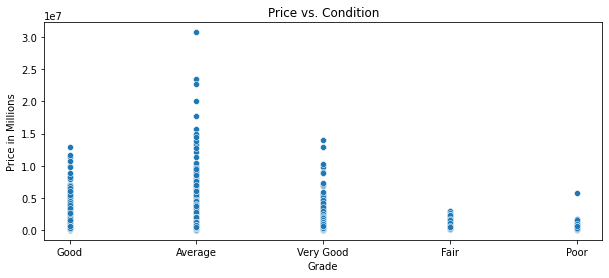

In [14]:
plt.figure(figsize = (10,4))
PvC = sns.scatterplot(x=kch_df['condition'], y=kch_df['price'], data=kch_df)
PvC.set(xlabel = 'Grade', ylabel = 'Price in Millions')
plt.title('Price vs. Condition')
plt.show()

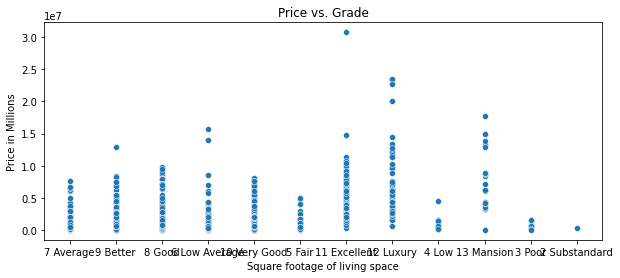

In [15]:
plt.figure(figsize = (10,4))
PvC = sns.scatterplot(x=kch_df['grade'], y=kch_df['price'], data=kch_df)
PvC.set(xlabel = 'Square footage of living space', ylabel = 'Price in Millions')
plt.title('Price vs. Grade')
plt.show()

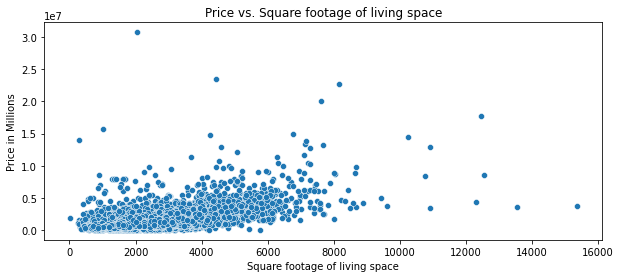

In [16]:
plt.figure(figsize = (10,4))
PvC = sns.scatterplot(x=kch_df['sqft_living'], y=kch_df['price'],data=kch_df)
PvC.set(xlabel = 'Square footage of living space', ylabel = 'Price in Millions')
plt.title('Price vs. Square footage of living space')
plt.show()

In [17]:
kch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30111 non-null  int64  
 1   date           30111 non-null  object 
 2   price          30111 non-null  float64
 3   bedrooms       30111 non-null  int64  
 4   bathrooms      30111 non-null  float64
 5   sqft_living    30111 non-null  int64  
 6   sqft_lot       30111 non-null  int64  
 7   floors         30111 non-null  float64
 8   waterfront     30111 non-null  object 
 9   greenbelt      30111 non-null  object 
 10  nuisance       30111 non-null  object 
 11  view           30111 non-null  object 
 12  condition      30111 non-null  object 
 13  grade          30111 non-null  object 
 14  heat_source    30111 non-null  object 
 15  sewer_system   30111 non-null  object 
 16  sqft_above     30111 non-null  int64  
 17  sqft_basement  30111 non-null  int64  
 18  sqft_g

Looking again at the variables in the dataset, I will make a decision on which variables to select that will affect house prices. Some of them would be potential targets for homeowners and real estates agents for renovation to increase property prices.

**Features to consider:** `bedrooms` `bathrooms` `sqft_living` `sqft_lot` `floors` `waterfront` `greenbelt` `nuisance` `view` `condition` `grade`

**Features to drop:** `id` `date` `heat_source` `sewer_system` `sqft_above` `sqft_basement` `sqft_garage` `sqft_patio` `yr_built` `yr_renovated` `address` `lat` `long` 

In [18]:
kch_clean = kch_df.drop(columns = ['id', 'date', 'heat_source', 'sewer_system', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built', 'yr_renovated', 'address', 'lat', 'long'])
#this information is not relevant to our model

In [19]:
kch_clean.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors
count,3.011100e+04,30111.000000,30111.000000,30111.000000,3.011100e+04,30111.000000
mean,1.108971e+06,3.415197,2.335708,2113.342798,1.664880e+04,1.543506
std,8.965158e+05,0.979755,0.888293,973.453260,5.993303e+04,0.567789
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000
25%,6.492360e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.477000e+03,1.500000
75%,1.300000e+06,4.000000,3.000000,2620.000000,1.056800e+04,2.000000
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000


bdrm_ohe = pd.get_dummies(kch_clean3['bedrooms'], prefix = 'bedrooms', drop_first=True)
bthrm_ohe = pd.get_dummies(kch_clean3['bathrooms'], prefix = 'bathrooms', drop_first=True)

In [30]:
#Current variables in the king dataset:
#Categorical variables:  bedrooms, bathrooms, waterfront, condition, grade, greenbelt, view, nuisance
#Continuous variables: price (target), floors, sqft_living, sqft_lot

#Identify categorical variables
categoricals = ['bedrooms','bathrooms','waterfront', 'condition', 'grade', 'greenbelt', 'view', 'nuisance']

#Implement dummies
bdrm_ohe = pd.get_dummies(kch_clean['bedrooms'], prefix = 'bedrooms', drop_first=True)
bthrm_ohe = pd.get_dummies(kch_clean['bathrooms'], prefix = 'bathrooms', drop_first=True)
wtrfrnt_ohe = pd.get_dummies(kch_clean['waterfront'], prefix = 'waterfront', drop_first=True)
cndtn_ohe = pd.get_dummies(kch_clean['condition'], prefix = 'condition', drop_first=True)
grd_ohe = pd.get_dummies(kch_clean['grade'], prefix = 'grade', drop_first=True)
grnblt_ohe = pd.get_dummies(kch_clean['greenbelt'], prefix = 'greenbelt', drop_first=True)
vw_ohe = pd.get_dummies(kch_clean['view'], prefix = 'view', drop_first=True)
nsnc_ohe = pd.get_dummies(kch_clean['nuisance'], prefix = 'nuisance', drop_first=True)


kch_prep = kch_clean.drop(columns = ['bedrooms', 'bathrooms','waterfront', 'condition', 'grade', 'greenbelt', 'view', 'nuisance'])

In [21]:
kch_ohe_prep = pd.concat([kch_prep, bdrm_ohe, bthrm_ohe, wtrfrnt_ohe, cndtn_ohe, grd_ohe, grnblt_ohe, vw_ohe, nsnc_ohe], axis=1)
kch_ohe_prep.head()

,price,sqft_living,sqft_lot,floors,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,...,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,greenbelt_YES,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,nuisance_YES
0,675000.0,1180,7140,1.0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
1,920000.0,2770,6703,1.0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,311000.0,2880,6156,1.0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,775000.0,2160,1400,2.0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,592500.0,1120,758,2.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1


In [22]:
# making a copy of the data without the target variable 'price'
kch_copy = kch_ohe_prep.drop(columns=['price'])

In [23]:
kch_copy.corr()

,sqft_living,sqft_lot,floors,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,...,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,greenbelt_YES,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,nuisance_YES
sqft_living,1.000000,0.122271,0.303911,-0.147184,-0.355999,-0.293510,0.311208,0.361343,0.193332,0.091551,...,-0.299025,-0.315183,0.068736,0.294754,0.116015,0.150799,0.046321,0.139110,-0.229305,-0.059094
sqft_lot,0.122271,1.000000,-0.031555,0.048683,-0.030151,-0.007705,0.016307,-0.000893,0.002550,-0.000698,...,0.006944,-0.048850,-0.030817,0.018501,-0.012706,0.035504,-0.005994,0.087490,-0.090312,0.012666
floors,0.303911,-0.031555,1.000000,-0.067023,-0.035572,-0.123004,0.107936,0.078613,0.029964,0.027293,...,-0.243413,-0.328327,0.234727,0.275449,0.065286,0.001799,-0.011038,0.002381,0.012634,-0.016244
bedrooms_1,-0.147184,0.048683,-0.067023,1.000000,-0.043828,-0.096987,-0.077394,-0.036204,-0.014680,-0.005843,...,0.091234,-0.043257,-0.057670,-0.034104,-0.016483,0.033431,0.004244,0.012197,-0.029467,0.028651
bedrooms_2,-0.355999,-0.030151,-0.035572,-0.043828,1.000000,-0.331692,-0.264685,-0.123817,-0.050206,-0.019982,...,0.228130,-0.026552,-0.035187,-0.084574,-0.035342,-0.004101,-0.010050,-0.024236,0.025836,0.071703
bedrooms_3,-0.293510,-0.007705,-0.123004,-0.096987,-0.331692,1.000000,-0.585724,-0.273997,-0.111102,-0.044219,...,0.013944,0.178512,-0.033512,-0.106065,-0.044564,-0.027326,-0.015095,-0.028874,0.050874,-0.002641
bedrooms_4,0.311208,0.016307,0.107936,-0.077394,-0.264685,-0.585724,1.000000,-0.218645,-0.088658,-0.035286,...,-0.140806,-0.100402,0.068285,0.120657,0.052812,0.002734,0.010818,0.023593,-0.023488,-0.053157
bedrooms_5,0.361343,-0.000893,0.078613,-0.036204,-0.123817,-0.273997,-0.218645,1.000000,-0.041473,-0.016507,...,-0.081165,-0.089715,0.016000,0.091657,0.036476,0.024005,0.019605,0.022887,-0.050734,-0.023248
bedrooms_6,0.193332,0.002550,0.029964,-0.014680,-0.050206,-0.111102,-0.088658,-0.041473,1.000000,-0.006693,...,-0.032164,-0.012496,-0.011500,0.018879,0.005325,0.005684,-0.001952,0.025544,-0.026779,0.033075
bedrooms_7,0.091551,-0.000698,0.027293,-0.005843,-0.019982,-0.044219,-0.035286,-0.016507,-0.006693,1.000000,...,-0.014491,-0.000088,-0.005533,-0.002149,0.007955,0.026722,0.003148,0.006407,-0.025094,0.015397


In [24]:
df=kch_copy.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [25]:
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,


With most variables hot encoded, there is no high collinearity.

### Model

Now we will start our modeling phase of the project.

#### Baseline Model

For the first iteration, I want to use the variable with biggest correlation with the target variable `price`.

In [26]:
# Checking price correlations with other columns
kch_ohe_prep.corrwith(kch_ohe_prep['price']).sort_values(ascending=False)

price                  1.000000
sqft_living            0.608616
grade_11 Excellent     0.317322
view_EXCELLENT         0.288665
grade_12 Luxury        0.283093
bathrooms_4.5          0.247375
waterfront_YES         0.235074
grade_9 Better         0.202460
bedrooms_5             0.201319
grade_13 Mansion       0.198162
bathrooms_3.5          0.195903
floors                 0.180589
bathrooms_5.0          0.164631
bathrooms_5.5          0.160143
bathrooms_6.5          0.149305
bathrooms_7.0          0.146509
bathrooms_4.0          0.131193
bathrooms_6.0          0.129058
bedrooms_4             0.122752
view_GOOD              0.121556
bedrooms_6             0.107035
sqft_lot               0.086550
bathrooms_7.5          0.069665
greenbelt_YES          0.067936
view_FAIR              0.060585
bathrooms_3.0          0.060079
bathrooms_8.5          0.059082
bathrooms_8.0          0.055374
bedrooms_7             0.045744
bathrooms_9.5          0.024964
bedrooms_8             0.019692
bedrooms

In [27]:
predictors = kch_copy # dataset without the price variable
X = kch_copy['sqft_living']
X_int = sm.add_constant(X)
y = kch_ohe_prep['price']


baseline_model = sm.OLS(y, X_int).fit()
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.771e+04
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        11:55:29   Log-Likelihood:            -4.4847e+05
No. Observations:               30111   AIC:                         8.969e+05
Df Residuals:                   30109   BIC:                         8.970e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.559e+04   9798.815     -7.714      0.000   -9.48e+04   -5.64e+04
sqft_living   560.5134      4.211    133.096      0.000     552.259     568.768
==============================================================================
Omnibus:                    43384.874   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         47187801.072
Skew:                           8.195   Prob(JB):                         0.00
Kurtosis:                     196.242   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Comments:**

**R-squared:**
The R-squared value of 0.370 indicate that the model explains about 37% of the variation in the dependent variable (price). This suggests the model has a reasonably good fit, but there is still a significant amount of unexplained variation.

**p value:** 
The extremely low Prob (F-statistic) value (< 0.00) indicate that the overall model is statistically significant, meaning the variable have a significant effect on the dependent variable.
We can reject the null hypothesis with a p value lower than 0.05.

The model has statistically significant predictors, but the relatively low R-squared suggests there is room for improvement in terms of explaining a larger proportion of the variation in property prices. The significant p-values are still valuable, as they identify the key drivers of price within the limitations of the current model.

**sqft_living:**
The coefficient for sqft_living is 560.5134, which is positive and statistically significant (p-value < 0.001). This indicates that for every additional square foot of living space, the price of the property increases by approximately $560. This makes sense, as larger living spaces are generally more valuable and command higher prices.

#### Second Model

For our second iteration we will log transform our `price` target variable and add more features in the hope of reaching a better R-square value.

In [32]:
#Log transform dataset
non_normal = ['price']

for feat in non_normal:
    kch_ohe_prep[feat] = kch_ohe_prep[feat].map(lambda x: np.log(x))

/Users/filippefontenele/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

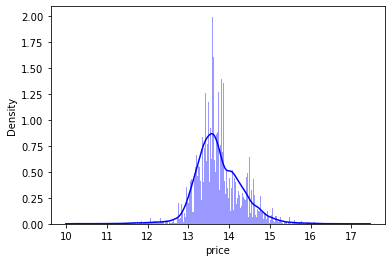

In [33]:
sns.distplot(kch_ohe_prep['price'], kde=True, bins=1000, color='blue')

In [34]:
# Checking price correlations with other columns
kch_ohe_prep.corrwith(kch_ohe_prep['price']).sort_values(ascending=False)

price                  1.000000
sqft_living            0.621995
grade_9 Better         0.283096
grade_11 Excellent     0.243749
floors                 0.234263
bathrooms_3.5          0.230439
bathrooms_4.5          0.215858
bedrooms_5             0.207707
view_EXCELLENT         0.199317
bedrooms_4             0.180355
grade_12 Luxury        0.167870
bathrooms_4.0          0.150006
waterfront_YES         0.138596
view_GOOD              0.127405
bathrooms_5.0          0.121776
bathrooms_3.0          0.119207
bathrooms_5.5          0.116461
bedrooms_6             0.100367
greenbelt_YES          0.097182
grade_13 Mansion       0.086235
sqft_lot               0.084701
bathrooms_6.0          0.082141
bathrooms_6.5          0.079137
grade_8 Good           0.068209
view_FAIR              0.064167
bathrooms_7.0          0.055990
bathrooms_7.5          0.042780
bedrooms_7             0.042311
bathrooms_2.5          0.033573
bathrooms_8.0          0.028566
bathrooms_8.5          0.023884
conditio

Using this as a base again, `grade` comes next with two variables from its one hot enconding. It is logical to go with this predictor now since a house with a better grade potentially yelds better prices in the market.

In [35]:
predictors1 = kch_copy[['sqft_living', 'grade_9 Better', 'grade_11 Excellent', 'grade_13 Mansion', 'grade_5 Fair', 'grade_6 Low Average' , 'grade_7 Average']]
X1 = predictors1
X_int1 = sm.add_constant(X1)
y = kch_ohe_prep['price']


In [37]:
second_model = sm.OLS(y, X_int1).fit()
second_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     3196.
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:25:40   Log-Likelihood:                -18062.
No. Observations:               30111   AIC:                         3.614e+04
Df Residuals:                   30103   BIC:                         3.621e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.2161      0.009   1437.005      0.000      13.198      13.234
sqft_living             0.0003   3.36e-06     84.060      0.000       0.000       0.000
grade_9 Better          0.1429      0.008     16.955      0.000       0.126       0.159
grade_11 Excellent      0.4288      0.023     18.275      0.000       0.383       0.475
grade_13 Mansion       -0.0023      0.092     -0.025      0.980      -0.183       0.178
grade_5 Fair           -0.3140      0.023    -13.401      0.000      -0.360      -0.268
grade_6 Low Average    -0.2962      0.010    -29.227      0.000      -0.316      -0.276
grade_7 Average        -0.1780      0.006    -28.144      0.000      -0.190      -0.166
==============================================================================
Omnibus:                     5910.998   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55829.583
Skew:                          -0.675   Prob(JB):                         0.00
Kurtosis:                       9.533   Cond. No.                     8.44e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Slightly improved model with an adjusted R-squared value of 37.1% and statistically significant with a Prob (F-statistic) of zero which is less than the alpha value of 0.05. However, all the model parameters, except for the `sqft_living` coefficient, are not statistically significant as their p-values are greater than the alpha value of 0.05. We will try to make our conditional variable work doing log transformation.

**Comments:**

**R-squared:**
The R-squared has increased from 0.370 to 0.426, and the Adjusted R-squared has also increased from 0.370 to 0.426. This indicates the model now explains about 42.6% of the variation in the log-transformed 'price' variable, which is a notable improvement over the previous model.

**p value:** 
All the variables, including the categorical 'grade' features, are now statistically significant (p-values < 0.001), except for the 'grade_13 Mansion' category.

Overall, the updated model with the log-transformed 'price' variable and the addition of the 'grade' categorical feature has shown significant improvements in terms of model fit, explanatory power, and the distribution of the dependent variable.

#### Third Model

For our next iteration, we will add more predictores and reach a better R-square value. Basing ourselves again in variables that correlate with our target, `bedrooms` and `bathrooms` come next. 

In [38]:
# Checking price correlations with other columns
kch_ohe_prep.corrwith(kch_ohe_prep['price']).sort_values(ascending=False)

price                  1.000000
sqft_living            0.621995
grade_9 Better         0.283096
grade_11 Excellent     0.243749
floors                 0.234263
bathrooms_3.5          0.230439
bathrooms_4.5          0.215858
bedrooms_5             0.207707
view_EXCELLENT         0.199317
bedrooms_4             0.180355
grade_12 Luxury        0.167870
bathrooms_4.0          0.150006
waterfront_YES         0.138596
view_GOOD              0.127405
bathrooms_5.0          0.121776
bathrooms_3.0          0.119207
bathrooms_5.5          0.116461
bedrooms_6             0.100367
greenbelt_YES          0.097182
grade_13 Mansion       0.086235
sqft_lot               0.084701
bathrooms_6.0          0.082141
bathrooms_6.5          0.079137
grade_8 Good           0.068209
view_FAIR              0.064167
bathrooms_7.0          0.055990
bathrooms_7.5          0.042780
bedrooms_7             0.042311
bathrooms_2.5          0.033573
bathrooms_8.0          0.028566
bathrooms_8.5          0.023884
conditio

In [41]:
kch_copy.columns

Index(['sqft_living', 'sqft_lot', 'floors', 'bedrooms_1', 'bedrooms_2',
       'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7',
       'bedrooms_8', 'bedrooms_9', 'bedrooms_10', 'bedrooms_11', 'bedrooms_13',
       'bathrooms_0.5', 'bathrooms_1.0', 'bathrooms_1.5', 'bathrooms_2.0',
       'bathrooms_2.5', 'bathrooms_3.0', 'bathrooms_3.5', 'bathrooms_4.0',
       'bathrooms_4.5', 'bathrooms_5.0', 'bathrooms_5.5', 'bathrooms_6.0',
       'bathrooms_6.5', 'bathrooms_7.0', 'bathrooms_7.5', 'bathrooms_8.0',
       'bathrooms_8.5', 'bathrooms_9.5', 'bathrooms_10.0', 'bathrooms_10.5',
       'waterfront_YES', 'condition_Fair', 'condition_Good', 'condition_Poor',
       'condition_Very Good', 'grade_11 Excellent', 'grade_12 Luxury',
       'grade_13 Mansion', 'grade_2 Substandard', 'grade_3 Poor',
       'grade_4 Low', 'grade_5 Fair', 'grade_6 Low Average', 'grade_7 Average',
       'grade_8 Good', 'grade_9 Better', 'greenbelt_YES', 'view_EXCELLENT',
       'view_FAIR', 'v

In [44]:
predictors2 = kch_copy[['sqft_living', 'grade_9 Better', 'grade_11 Excellent', 'grade_13 Mansion', 'grade_5 Fair', 'grade_6 Low Average' , 'grade_7 Average',
                       'bedrooms_1', 'bedrooms_2',
       'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7',
       'bedrooms_8', 'bedrooms_9', 'bedrooms_10', 'bedrooms_11', 'bedrooms_13',
       'bathrooms_0.5', 'bathrooms_1.0', 'bathrooms_1.5', 'bathrooms_2.0',
       'bathrooms_2.5', 'bathrooms_3.0', 'bathrooms_3.5', 'bathrooms_4.0',
       'bathrooms_4.5', 'bathrooms_5.0', 'bathrooms_5.5', 'bathrooms_6.0',
       'bathrooms_6.5', 'bathrooms_7.0', 'bathrooms_7.5', 'bathrooms_8.0',
       'bathrooms_8.5', 'bathrooms_9.5', 'bathrooms_10.0', 'bathrooms_10.5',]]
X2 = predictors2
X_int2 = sm.add_constant(X2)
y = kch_ohe_prep['price']

In [45]:
# Third model
third_model = sm.OLS(y, X_int2).fit()
third_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     599.5
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:17:34   Log-Likelihood:                -17768.
No. Observations:               30111   AIC:                         3.562e+04
Df Residuals:                   30071   BIC:                         3.595e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  13.2070      0.089    148.011      0.000      13.032      13.382
sqft_living             0.0003   5.01e-06     58.061      0.000       0.000       0.000
grade_9 Better          0.1384      0.008     16.473      0.000       0.122       0.155
grade_11 Excellent      0.3537      0.024     14.898      0.000       0.307       0.400
grade_13 Mansion       -0.1702      0.099     -1.722      0.085      -0.364       0.024
grade_5 Fair           -0.4065      0.025    -16.462      0.000      -0.455      -0.358
grade_6 Low Average    -0.3368      0.011    -29.931      0.000      -0.359      -0.315
grade_7 Average        -0.1834      0.007    -27.350      0.000      -0.197      -0.170
bedrooms_1             -0.4555      0.097     -4.697      0.000      -0.646      -0.265
bedrooms_2             -0.5947      0.095     -6.268      0.000      -0.781      -0.409
bedrooms_3             -0.6318      0.095     -6.660      0.000      -0.818      -0.446
bedrooms_4             -0.6618      0.095     -6.963      0.000      -0.848      -0.476
bedrooms_5             -0.6991      0.095     -7.323      0.000      -0.886      -0.512
bedrooms_6             -0.7314      0.097     -7.521      0.000      -0.922      -0.541
bedrooms_7             -0.7707      0.107     -7.173      0.000      -0.981      -0.560
bedrooms_8             -0.8001      0.119     -6.697      0.000      -1.034      -0.566
bedrooms_9             -0.8715      0.152     -5.724      0.000      -1.170      -0.573
bedrooms_10            -0.9573      0.277     -3.458      0.001      -1.500      -0.415
bedrooms_11            -0.4719      0.447     -1.055      0.292      -1.349       0.405
bedrooms_13            -3.5079      0.627     -5.591      0.000      -4.738      -2.278
bathrooms_0.5           0.7753      0.229      3.390      0.001       0.327       1.224
bathrooms_1.0           0.6563      0.118      5.545      0.000       0.424       0.888
bathrooms_1.5           0.6099      0.119      5.139      0.000       0.377       0.843
bathrooms_2.0           0.6638      0.118      5.608      0.000       0.432       0.896
bathrooms_2.5           0.5792      0.118      4.893      0.000       0.347       0.811
bathrooms_3.0           0.6520      0.119      5.502      0.000       0.420       0.884
bathrooms_3.5           0.7014      0.119      5.908      0.000       0.469       0.934
bathrooms_4.0           0.7299      0.120      6.103      0.000       0.496       0.964
bathrooms_4.5           0.8051      0.120      6.701      0.000       0.570       1.041
bathrooms_5.0           0.7841      0.124      6.309      0.000       0.540       1.028
bathrooms_5.5           0.7557      0.127      5.962      0.000       0.507       1.004
bathrooms_6.0           0.8533      0.136      6.260      0.000       0.586       1.120
bat

**Comments:**

**R-squared:**
The R-squared and Adjusted R-squared for the third model are both 0.437, which is higher than the previous two models (0.370 and 0.426 respectively).
This indicates the third model explains a larger proportion of the variance in the log-transformed 'price' variable compared to the earlier models.

**p value:** 
The third model includes more categorical variables (bedrooms and bathrooms) compared to the previous models.
Most of these new categorical variables are statistically significant, with p-values less than 0.05, except for a few (e.g., 'bedrooms_11', 'bathrooms_9.5', 'bathrooms_10.5').
The previously significant variables, such as 'sqft_living' and the 'grade' categories, remain statistically significant in the third model as well.

The third model, with the addition of the 'bedrooms' and 'bathrooms' categorical features, has the highest R-squared and Adjusted R-squared among the three models, indicating it has the best overall fit and explanatory power.


In [47]:
# Baseline Model
y_true = kch_ohe_prep['price']
y_pred = baseline_model.predict(X_int)
baseline_mse = np.mean((y_true - y_pred)**2)
print(f"Baseline Model MSE: {baseline_mse:.4f}")

# Second Model
y_true = kch_ohe_prep['price']
y_pred = second_model.predict(X_int1)
second_mse = np.mean((y_true - y_pred)**2)
print(f"Second Model MSE: {second_mse:.4f}")

# Third Model 
y_true = kch_ohe_prep['price']
y_pred = third_model.predict(X_int2)
third_mse = np.mean((y_true - y_pred)**2)
print(f"Third Model MSE: {third_mse:.4f}")

Baseline Model MSE: 1527491218502.0830
Second Model MSE: 0.1943
Third Model MSE: 0.1906


###  Interpret

We will validate the model using Mean Square Error to check if our iterations are evolving or if we need to do one more.

#### Model Validation

In [48]:
# Baseline Model
y_true = kch_ohe_prep['price']
y_pred = baseline_model.predict(X_int)
baseline_mse = np.mean((y_true - y_pred)**2)
print(f"Baseline Model MSE: {baseline_mse:.4f}")

# Second Model
y_true = kch_ohe_prep['price']
y_pred = second_model.predict(X_int1)
second_mse = np.mean((y_true - y_pred)**2)
print(f"Second Model MSE: {second_mse:.4f}")

# Third Model 
y_true = kch_ohe_prep['price']
y_pred = third_model.predict(X_int2)
third_mse = np.mean((y_true - y_pred)**2)
print(f"Third Model MSE: {third_mse:.4f}")

Baseline Model MSE: 1527491218502.0830
Second Model MSE: 0.1943
Third Model MSE: 0.1906


The baseline model has an extremely high and unacceptable MSE, indicating very poor predictive performance.

The second and third models have much lower, acceptable MSE values, with the third model performing slightly better than the second.

The lower MSE values for the second and third models suggest they are making significantly smaller errors in their predictions compared to the baseline model.

The MSE results provide a clear quantitative comparison of the predictive accuracy of the three models, with the third model appearing to be the best performer based on this metric.

#### Conclusion

The OLS regression model provides valuable insights into the key factors that influence property prices in this market. The analysis reveals several important findings:

**Square Footage:** The 'sqft_living' variable has a positive and statistically significant coefficient, indicating that properties with larger living spaces tend to command higher prices. This suggests that homeowners and real estate agents should prioritize maximizing the livable square footage when preparing a property for sale or evaluating a potential purchase.

**Property Grades:** The 'grade' variables show that properties with higher quality grades (e.g., 'grade_11 Excellent') have significantly higher prices compared to lower-grade properties. This highlights the importance of maintaining and improving the overall quality and condition of a home, as it can substantially impact the sale price.

**Number of Bathrooms:** In contrast to the bedrooms, the 'bathrooms' variables have positive and statistically significant coefficients, indicating that properties with more bathrooms tend to have higher prices. This suggests that real estate agents and homeowners should prioritize the number and quality of bathrooms when preparing a property for sale or evaluating a potential purchase.

Overall, the results of this OLS regression model provide clear guidance for real estate agents and homeowners on the key features they should focus on to maximize the sale price of a property. By prioritizing larger living spaces, higher-quality property grades and a sufficient number of bathrooms, they can position their properties to be more attractive to buyers and achieve higher sale prices.